In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# 1. Veri Yükleme ve İnceleme
data = pd.read_excel('/content/drive/MyDrive/data_set.xlsx')
print(data.head())

                                               Yorum    Kategori   Duygu
0               Beklentilerimi fazlasıyla karşıladı.       Giyim  Olumlu
1  Kullanımı kolay ama malzeme kalitesi daha iyi ...  Elektronik    Nötr
2  Paketleme güzeldi ama ürün beklentilerimi karş...  Elektronik    Nötr
3                   Ürün harika, tam istediğim gibi!  Elektronik  Olumlu
4            Kargo hızlıydı, ürün de sorunsuz geldi.       Giyim  Olumlu


In [54]:
#2.  Metin Önişleme

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')  # Ensure compatibility with the latest version


def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldır
    text = text.lower()  # Küçük harfe dönüştür
    text = text.strip()  # Boşlukları temizle
    words = text.split()
    stop_words = set(stopwords.words('turkish'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

data['processed_text'] = data['Yorum'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
# Uygula
data['processed_text'] = data['Yorum'].apply(preprocess_text)

# Metin sütununu önişle
data['processed_text'] = data['Yorum'].apply(preprocess_text)
# İlk beş işlenmiş metni göster
print(data['processed_text'].head())

0                  beklentilerimi fazlasıyla karşıladı
1      kullanımı kolay malzeme kalitesi iyi olabilirdi
2    paketleme güzeldi ürün beklentilerimi karşılamadı
3                            ürün harika tam istediğim
4                   kargo hızlıydı ürün sorunsuz geldi
Name: processed_text, dtype: object


In [56]:
# 3. Veri Temsili Yöntemleri
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(X)

# Word2Vec
# Öncelikle metinleri kelime listelerine çeviriyoruz
X_words = [text.lower().split() for text in X]
w2v_model = Word2Vec(sentences=X_words, vector_size=100, window=5, min_count=2, sg=1)

# Ortalama Word2Vec temsili
def get_average_w2v(text, model, vector_size):
    words = text.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vecs, axis=0)

X_w2v = np.array([get_average_w2v(text, w2v_model, 100) for text in X])

In [57]:
# Eğitim ve Test Verisi Ayırma
X = data['processed_text']
y = data['Duygu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# TF-IDF ile Özellik Çıkarımı
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [59]:
from sklearn.model_selection import train_test_split, KFold
# 10-katlı çapraz doğrulama için KFold nesnesi oluşturma
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# KFold ile çapraz doğrulama indexlerini yazdırma
for train_index, test_index in kf.split(X_train_tfidf):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 1197 1198 1199] TEST: [  23   43   44   49   51   54   56   58   70   78   81   86  101  107
  109  113  123  135  140  155  156  158  163  168  170  174  184  192
  210  218  240  243  244  277  286  292  309  321  323  332  342  344
  354  355  358  362  367  371  377  380  381  390  411  423  425  427
  430  438  439  461  490  513  523  534  548  549  570  582  596  598
  609  615  621  652  670  676  677  692  727  735  737  739  745  765
  820  838  844  849  850  855  865  881  889  893  908  909  936  942
  950  974  988  991  994 1001 1007 1018 1022 1037 1065 1072 1101 1108
 1115 1120 1135 1163 1166 1172 1178 1191]
TRAIN: [   0    1    2 ... 1197 1198 1199] TEST: [  10   31   59   83   88   96  128  129  178  198  199  208  209  220
  231  233  247  260  265  270  274  275  290  294  296  298  306  308
  314  319  327  328  333  382  394  413  415  429  433  462  471  478
  481  497  506  519  532  533  542  558  560  597  620  622  626  630
  631  6

In [60]:
# Eğitim ve test kümelerinin boyutlarını yazdır
print(f"Eğitim kümesi boyutu: {X_train_tfidf.shape[0]}, Test kümesi boyutu: {X_test_tfidf.shape[0]}")

Eğitim kümesi boyutu: 1200, Test kümesi boyutu: 300


In [61]:


# Modelleri tanımlama
models = {
"Lojistik Regresyon": LogisticRegression(max_iter=1000),
"Karar Ağacı": DecisionTreeClassifier(),
"Rastgele Orman": RandomForestClassifier(),
"SVM": SVC(),
"KNN": KNeighborsClassifier()
}

In [62]:
# Seçilen öznitelik seti (örnek olarak TF-IDF kullanıyorum)
# X_tfidf değişkenini oluşturmak için tüm veriyi TF-IDF ile vektörleştir
tfidf_vectorizer = TfidfVectorizer() # TF-IDF nesnesini oluştur
X_tfidf = tfidf_vectorizer.fit_transform(X) # Tüm veriyi (X) vektörleştir

features = X_tfidf
target = y # labels yerine y kullanılmalı (Duygu sütunu)
# Her model için çapraz doğrulama ile performans değerlendirme
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, features, target, cv=10)
    results[name] = cv_scores
    print(f"{name} Ortalama Doğruluk: {cv_scores.mean()*100:.2f}%") # Her model için sonuç yazdır

Lojistik Regresyon Ortalama Doğruluk: 99.40%
Karar Ağacı Ortalama Doğruluk: 97.73%
Rastgele Orman Ortalama Doğruluk: 98.73%
SVM Ortalama Doğruluk: 99.33%
KNN Ortalama Doğruluk: 96.13%


In [63]:
# Sonuçları yazdır
for model_name, scores in results.items():
    print(f"{model_name} modelinin ortalama doğruluk skoru: {scores.mean():.2f}, Standart Sapma: {scores.std():.2f}")

Lojistik Regresyon modelinin ortalama doğruluk skoru: 0.99, Standart Sapma: 0.02
Karar Ağacı modelinin ortalama doğruluk skoru: 0.98, Standart Sapma: 0.05
Rastgele Orman modelinin ortalama doğruluk skoru: 0.99, Standart Sapma: 0.03
SVM modelinin ortalama doğruluk skoru: 0.99, Standart Sapma: 0.01
KNN modelinin ortalama doğruluk skoru: 0.96, Standart Sapma: 0.07


In [64]:
# TF ve TF-IDF hesaplama
tf_vectorizer = CountVectorizer(analyzer=lambda x: x)
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)
tf_matrix = tf_vectorizer.fit_transform(data['processed_text'])
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_text'])
# Etiketleri ayarla
labels = data['Duygu']


# Eğitim ve test kümelerini ayır
X_train_tf, X_test_tf, y_train, y_test = train_test_split(tf_matrix, labels, test_size=0.2,random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)
# Sınıflandırıcıları tanımla
models = {
    "Naive Bayes": MultinomialNB(),
     "Lojistik Regresyon": LogisticRegression (max_iter=1000),
    "Karar Ağacı": DecisionTreeClassifier(),
    "Rastgele Orman": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}


In [65]:
from sklearn.metrics import accuracy_score, classification_report

for name, model in models.items():
    print(f"\nModel: {name}")

    # TF ile eğitim ve test
    print("\nUsing Term Frequency (TF):")
    model.fit(X_train_tf, y_train)
    predictions_tf = model.predict(X_test_tf)
    print(f"Accuracy (TF): {accuracy_score(y_test, predictions_tf):.4f}")
    print(classification_report(y_test, predictions_tf))

    # TF-IDF ile eğitim ve test
    print("\nUsing Term Frequency-Inverse Document Frequency (TF-IDF):")
    model.fit(X_train_tfidf, y_train)
    predictions_tfidf = model.predict(X_test_tfidf)
    print(f"Accuracy (TF-IDF): {accuracy_score(y_test, predictions_tfidf):.4f}")
    print(classification_report(y_test, predictions_tfidf))


Model: Naive Bayes

Using Term Frequency (TF):
Accuracy (TF): 0.6700
              precision    recall  f1-score   support

        Nötr       0.64      0.78      0.70       107
      Olumlu       0.67      0.69      0.68        91
     Olumsuz       0.72      0.54      0.62       102

    accuracy                           0.67       300
   macro avg       0.68      0.67      0.67       300
weighted avg       0.68      0.67      0.67       300


Using Term Frequency-Inverse Document Frequency (TF-IDF):
Accuracy (TF-IDF): 0.6300
              precision    recall  f1-score   support

        Nötr       0.59      0.65      0.62       107
      Olumlu       0.66      0.67      0.66        91
     Olumsuz       0.65      0.57      0.61       102

    accuracy                           0.63       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.63      0.63      0.63       300


Model: Lojistik Regresyon

Using Term Frequency (TF):
Accuracy (TF): 0.7600
      

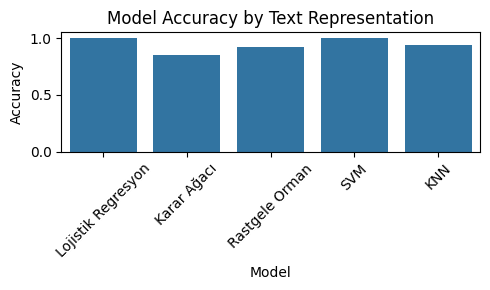

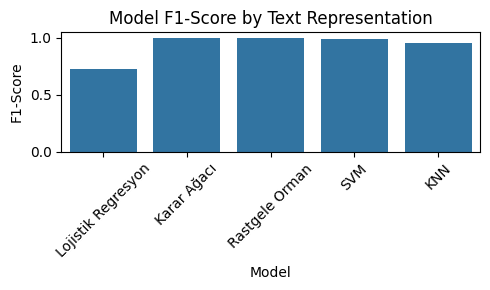

In [72]:
# Sonuçları Görselleştirme
results_df = pd.DataFrame(results)

# results_df'ye Model sütunu ekle
results_df = results_df.T.reset_index()  # Transpose and reset index
results_df = results_df.rename(columns={'index': 'Model'}) # Rename index column to 'Model'

# Doğruluk Grafiği
plt.figure(figsize=(5, 3))
sns.barplot(data=results_df, x="Model", y=0,  # Use column 0 for y-axis
            #hue="Representation"  # Remove hue for now
           )
plt.title("Model Accuracy by Text Representation")
plt.ylabel("Accuracy")
plt.xlabel("Model")
#plt.legend(title="Representation")  # Remove legend for now
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



f1_scores = []
# Use the same models as in results_df to calculate F1-scores
for model_name in results_df['Model']: # Iterate over model names in results_df
    model = models[model_name] # Get the model from the models dictionary
    model.fit(X_train_tfidf, y_train)  # Modeli eğit (TF-IDF kullanarak)
    y_pred = model.predict(X_test_tfidf)  # Tahminleri yap
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1-Score'u hesapla
    f1_scores.append(f1)

results_df['F1-Score'] = f1_scores  # F1-Score'u results_df'ye ekle


plt.figure(figsize=(5, 3))
sns.barplot(data=results_df, x="Model", y="F1-Score") # "F1-Score" sütununu kullan
plt.title("Model F1-Score by Text Representation")
plt.ylabel("F1-Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
